In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from matplotlib.pyplot import cm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
# Set GPU as the default device
tf.config.experimental.set_visible_devices(tf.config.experimental.list_physical_devices('GPU')[0], 'GPU')

# Verify that GPU is the default device
print("Default Device: ", tf.test.gpu_device_name())

Default Device:  /device:GPU:0


In [ ]:
!unzip drive/MyDrive/project2.zip

Archive:  drive/MyDrive/project2.zip
   creating: project2/
  inflating: project2/corridor_both_directions_revised.txt  
  inflating: project2/corridor_both_directions_revised_dataset.txt  
  inflating: project2/data_preprocessing.py  
  inflating: project2/left_turn_revised.txt  
  inflating: project2/left_turn_revised_dataset.txt  
  inflating: project2/supermarket_revised.txt  
  inflating: project2/supermarket_revised_dataset.txt  


In [ ]:
corridor_data = pd.read_csv("./project2/corridor_both_directions_revised.txt", sep=" ")
corridor_data

,timeStep,pedestrianId,x,y
0,1,1,17.701000,0.701000
1,1,2,18.103000,0.701000
2,1,3,18.505000,0.701000
3,1,4,17.701000,1.103000
4,1,5,18.103000,1.103000
...,...,...,...,...
6906,98,21,4.806480,3.390884
6907,98,24,4.181434,2.265993
6908,98,41,15.714690,1.705257
6909,98,61,1.209621,2.454183


In [ ]:
from preprocessing import *
from creating_preprocessing_data import *

In [ ]:
from scipy.spatial import distance 

In [ ]:
def remove_diagonal(A):
    return A[~np.eye(A.shape[0],dtype=bool)].reshape(A.shape[0],-1)

In [ ]:
NO_NEIGHBORS = 5
TIMESTEP_LENGTH = 0.4

dic = {
    'timestep': [],
    'pid': [],
    'pos': [],
    'mean_spacing': [],
    'speed': [],
    'knn': []
}

for timestep in range(1, corridor_data.timeStep.max()):
    frame = corridor_data[corridor_data.timeStep == timestep]
    next_frame = corridor_data[corridor_data.timeStep == timestep + 1]

    frame = frame[frame['pedestrianId'].isin(next_frame['pedestrianId'])]
    next_frame = next_frame[next_frame['pedestrianId'].isin(frame['pedestrianId'])]

    if len(frame) <= NO_NEIGHBORS:
        continue

    pos = frame[['x', 'y']].to_numpy()
    next_pos = next_frame[['x', 'y']].to_numpy()

    dist = distance.squareform(distance.pdist(pos))
    dist = remove_diagonal(dist)[:, :NO_NEIGHBORS]

    knn = np.argsort(dist, axis=1)

    dic['timestep'] += frame.timeStep.to_list()
    dic['pid'] += frame.pedestrianId.to_list()
    dic['pos'] += pos.tolist()
    dic['mean_spacing'] += dist.mean(axis = 1).tolist()
    dic['speed'] += (np.linalg.norm(next_pos - pos, axis=1) / TIMESTEP_LENGTH).tolist() 
    dic['knn'] += (pos[knn] - pos[:, np.newaxis]).tolist()

In [ ]:
corridor_temp = pd.DataFrame(dic)
# df2.to_csv('data/corridor_both_directions.csv', sep=' ', index=False)
corridor_temp

,timestep,pid,pos,mean_spacing,speed,knn
0,1,1,"[17.701, 0.7010000000000001]",0.615083,1.558207,"[[0.8039999999999985, 0.0], [0.0, 0.0], [0.0, ..."
1,1,2,"[18.103, 0.7010000000000001]",0.468606,1.118237,"[[0.0, 0.0], [-0.402000000000001, 0.4020000000..."
2,1,3,"[18.505, 0.7010000000000001]",0.615083,1.225062,"[[-0.40199999999999747, 0.0], [-0.401999999999..."
3,1,4,"[17.701, 1.1030000000000002]",0.615083,1.406499,"[[0.0, -0.40200000000000014], [0.0, 0.0], [0.4..."
4,1,5,"[18.103, 1.1030000000000002]",0.468606,0.597641,"[[0.0, 0.0], [0.0, -0.40200000000000014], [-0...."
...,...,...,...,...,...,...
6806,97,21,"[5.181136793745895, 3.385073455881704]",4.644860,0.936756,"[[0.0, 0.0], [-3.667156217732756, 0.3749043992..."
6807,97,24,"[4.720948195807343, 2.2659927824467654]",4.390301,1.348784,"[[0.4601885979385525, 1.1190806734349388], [10..."
6808,97,41,"[15.330413479996816, 1.7052568064425038]",12.504181,0.960692,"[[-10.149276686250921, 1.6798166494392004], [-..."
6809,97,61,"[1.4479074099845006, 2.480854747643503]",4.722096,0.599436,"[[0.06607316602863844, 1.2791231074759701], [0..."


In [ ]:
corridor_processed = convert_df(corridor_temp)
corridor_processed

,timestep,pid,speed,mean_spacing,ID,X,Y,0,1,2,3,4,5,6,7,8,9
0,1,1,1.558207,0.615083,1,17.701000,0.701000,0.804000,0.000000,0.000000,0.000000,0.000000,0.402000,0.402000,0.000000,0.402000,0.402000
1,1,2,1.118237,0.468606,2,18.103000,0.701000,0.000000,0.000000,-0.402000,0.402000,-0.402000,0.000000,0.000000,0.402000,0.402000,0.000000
2,1,3,1.225062,0.615083,3,18.505000,0.701000,-0.402000,0.000000,-0.402000,0.402000,-0.804000,0.402000,-0.804000,0.000000,0.000000,0.000000
3,1,4,1.406499,0.615083,4,17.701000,1.103000,0.000000,-0.402000,0.000000,0.000000,0.402000,-0.402000,0.402000,0.000000,0.804000,-0.402000
4,1,5,0.597641,0.468606,5,18.103000,1.103000,0.000000,0.000000,0.000000,-0.402000,-0.402000,0.000000,0.402000,-0.402000,-0.402000,-0.402000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6806,97,21,0.936756,4.644860,21,5.181137,3.385073,0.000000,0.000000,-3.667156,0.374904,10.149277,-1.679817,-3.577649,-2.199141,-0.460189,-1.119081
6807,97,24,1.348784,4.390301,24,4.720948,2.265993,0.460189,1.119081,10.609465,-0.560736,-3.117460,-1.080061,-3.206968,1.493985,0.000000,0.000000
6808,97,41,0.960692,12.504181,41,15.330413,1.705257,-10.149277,1.679817,-10.609465,0.560736,-13.726925,-0.519325,0.000000,0.000000,-13.816433,2.054721
6809,97,61,0.599436,4.722096,61,1.447907,2.480855,0.066073,1.279123,0.155581,-1.294923,3.273041,-0.214862,3.733229,0.904219,13.882506,-0.775598


In [ ]:
print(corridor_processed.shape)

(6811, 17)


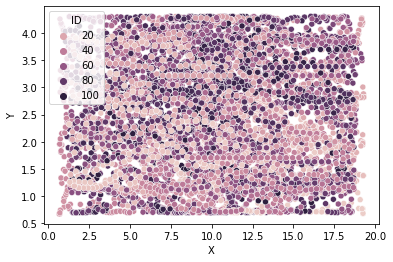

In [ ]:
sns.scatterplot(x="X", y="Y", hue="ID", data=corridor_processed)

In [ ]:
corridor_processed.describe()

,timestep,pid,speed,mean_spacing,ID,X,Y,0,1,2,3,4,5,6,7,8,9
count,6811.000000,6811.000000,6811.000000,6811.000000,6811.000000,6811.000000,6811.000000,6811.000000,6811.000000,6811.000000,6811.000000,6811.000000,6811.000000,6811.000000,6811.000000,6811.000000,6811.000000
mean,38.821318,50.200411,0.738668,5.482438,50.200411,10.019194,2.480994,0.988496,-0.973472,1.006564,-0.934977,1.210729,-1.039658,1.108615,-0.945443,1.870990,-1.006814
std,23.246769,28.928164,0.434237,3.089759,28.928164,4.723482,1.088697,4.007060,1.148195,4.820033,1.280435,5.638910,1.306653,6.815703,1.469718,9.035196,1.255756
min,1.000000,1.000000,0.000000,0.468606,1.000000,0.689360,0.672843,-15.097524,-3.620954,-15.699699,-3.613602,-16.032873,-3.610482,-16.798842,-3.621700,-17.474581,-3.615417
25%,19.000000,24.000000,0.415462,3.523642,24.000000,6.419594,1.500551,-0.850699,-1.832166,-2.134091,-1.924336,-3.174337,-2.078180,-4.643048,-2.126059,-6.753000,-1.998716
50%,37.000000,49.000000,0.691268,4.633963,49.000000,10.038526,2.485658,0.356268,-0.939141,0.717631,-0.897422,1.567740,-1.062613,2.086407,-1.004950,3.890720,-1.020786
75%,56.000000,76.000000,1.079688,6.286256,76.000000,13.555277,3.437256,1.858081,-0.051800,3.307488,0.000000,4.685614,-0.004094,5.813571,0.036645,8.830390,-0.023583
max,97.000000,100.000000,2.058220,16.911665,100.000000,19.300276,4.305892,16.200000,2.580437,16.222131,2.758919,16.677287,2.857030,17.218841,3.212443,18.563458,3.268618


In [ ]:
print(corridor_processed.dtypes)

timestep          int64
pid               int64
speed           float64
mean_spacing    float64
ID                int64
X               float64
Y               float64
0               float64
1               float64
2               float64
3               float64
4               float64
5               float64
6               float64
7               float64
8               float64
9               float64
dtype: object


In [ ]:
X = corridor_processed[["timestep", "X", "Y", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "mean_spacing"]]
y = corridor_processed["speed"]

X

,timestep,X,Y,0,1,2,3,4,5,6,7,8,9,mean_spacing
0,1,17.701000,0.701000,0.804000,0.000000,0.000000,0.000000,0.000000,0.402000,0.402000,0.000000,0.402000,0.402000,0.615083
1,1,18.103000,0.701000,0.000000,0.000000,-0.402000,0.402000,-0.402000,0.000000,0.000000,0.402000,0.402000,0.000000,0.468606
2,1,18.505000,0.701000,-0.402000,0.000000,-0.402000,0.402000,-0.804000,0.402000,-0.804000,0.000000,0.000000,0.000000,0.615083
3,1,17.701000,1.103000,0.000000,-0.402000,0.000000,0.000000,0.402000,-0.402000,0.402000,0.000000,0.804000,-0.402000,0.615083
4,1,18.103000,1.103000,0.000000,0.000000,0.000000,-0.402000,-0.402000,0.000000,0.402000,-0.402000,-0.402000,-0.402000,0.468606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6806,97,5.181137,3.385073,0.000000,0.000000,-3.667156,0.374904,10.149277,-1.679817,-3.577649,-2.199141,-0.460189,-1.119081,4.644860
6807,97,4.720948,2.265993,0.460189,1.119081,10.609465,-0.560736,-3.117460,-1.080061,-3.206968,1.493985,0.000000,0.000000,4.390301
6808,97,15.330413,1.705257,-10.149277,1.679817,-10.609465,0.560736,-13.726925,-0.519325,0.000000,0.000000,-13.816433,2.054721,12.504181
6809,97,1.447907,2.480855,0.066073,1.279123,0.155581,-1.294923,3.273041,-0.214862,3.733229,0.904219,13.882506,-0.775598,4.722096


In [ ]:
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import resample
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score ,KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

Average MSE: 0.7383491614345121
Test MSE: 0.7340906552917311


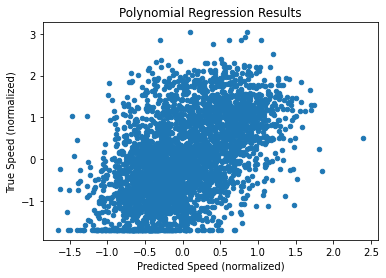

In [ ]:
# Split the data into features (X) and target (y)
X = corridor_processed[["timestep", "X", "Y", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "mean_spacing"]]
y = corridor_processed["speed"]

# Load the data
scaler_X = StandardScaler()

# Fit the scaler on X
scaler_X.fit(X)

# Transform X
X = scaler_X.transform(X)

# Initialize the scaler for y
scaler_y = StandardScaler()

# Fit the scaler on y
scaler_y.fit(y.values.reshape(-1, 1))

# Transform y
y = scaler_y.transform(y.values.reshape(-1, 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=101)

"""
# normalize the input (X) and output (y) separately using StandardScaler
X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_test = y_scaler.transform(y_test.reshape(-1, 1))
"""
# create a pipeline that combines normalization and regression
model = Pipeline([
  ('poly', PolynomialFeatures(degree=2)),
  ('regression', LinearRegression())
])

# use KFold cross-validation to evaluate the model
kfold = KFold(n_splits=5, shuffle=True, random_state=101)
scores = []
for train_index, val_index in kfold.split(X_train):
  X_train_fold, X_val = X_train[train_index], X_train[val_index]
  y_train_fold, y_val = y_train[train_index], y_train[val_index]

  # fit the model to the training data
  model.fit(X_train_fold, y_train_fold)

  # evaluate the model on the validation data
  y_val_pred = model.predict(X_val)
  score = mean_squared_error(y_val, y_val_pred)
  scores.append(score)

# print the average mean squared error across the 5 folds
print("Average MSE:", np.mean(scores))

# evaluate the model on the test data
y_test_pred = model.predict(X_test)
test_score = mean_squared_error(y_test, y_test_pred)
print("Test MSE:", test_score)

# plot the regression results
plt.scatter(y_test_pred, y_test, s=20)
plt.xlabel("Predicted Speed (normalized)")
plt.ylabel("True Speed (normalized)")
plt.title("Polynomial Regression Results")
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import resample

In [ ]:
# Create separate arrays for input (X) and output (y)
X = corridor_processed[["timestep", "X", "Y", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "mean_spacing"]]
y = corridor_processed["speed"]

# Load the data
scaler_X = StandardScaler()

# Fit the scaler on X
scaler_X.fit(X)

# Transform X
X = scaler_X.transform(X)

# Initialize the scaler for y
scaler_y = StandardScaler()

# Fit the scaler on y
scaler_y.fit(y.values.reshape(-1, 1))

# Transform y
y = scaler_y.transform(y.values.reshape(-1, 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
# Initialize a list to store the training, validation, and testing losses
training_losses = []
validation_losses = []
testing_losses = []
testing_accuracy = []

# Define the number of folds for the cross validation
n_folds = 5

# Initialize the KFold object for cross validation
kf = KFold(n_folds)

# Define the number of subsamples for the bootstrapping
n_subsamples = 30

# Loop over the subsamples
for i in range(n_subsamples):
    # Bootstrap the training data
    X_train_sub, y_train_sub = resample(X_train, y_train, random_state=i)
    print("We are in subsample:{} out of 30".format(i))
    
    # Loop over the folds for cross validation
    for train_index, val_index in kf.split(X_train_sub):
        X_train_cv, X_val = X_train_sub[train_index], X_train_sub[val_index]
        y_train_cv, y_val = y_train_sub[train_index], y_train_sub[val_index]
        
        # Build the model
        with tf.device('/GPU:0'):
          model = Sequential()
          model.add(Dense(units = 3, activation='relu', input_shape=(X_train_cv.shape[1],)))
          model.add(Dense(1))
          model.compile(optimizer='adam', loss='mean_squared_error')

        # Add Early stopping in case the model overfits
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
        
        # Train the model on the training data
        with tf.device('/GPU:0'):
          history = model.fit(X_train_cv, y_train_cv, epochs=75, verbose=1,validation_data=(X_val, y_val), callbacks=[early_stopping])
    
        # Evaluate the model on the validation data
        with tf.device('/GPU:0'):
          val_loss = model.evaluate(X_val, y_val, verbose=1)
          validation_losses.append(val_loss)
        
        # Evaluate the model on the testing data
        with tf.device('/GPU:0'):
          test_loss= model.evaluate(X_test, y_test, verbose=1)
          testing_losses.append(test_loss)
#Calculate the mean and standard deviation of the training loss

mean_training_loss = np.mean(history.history['loss'])
std_training_loss = np.std(history.history['loss'])
training_losses.append((mean_training_loss, std_training_loss))

#Calculate the mean and standard deviation of the validation losses

mean_validation_loss = np.mean(validation_losses)
std_validation_loss = np.std(validation_losses)

#Calculate the mean and standard deviation of the testing losses
mean_testing_loss = np.mean(testing_losses)
std_testing_loss = np.std(testing_losses)


print("Mean training loss: {:.4f} +/- {:.4f}".format(mean_training_loss, std_training_loss))
print("Mean validation loss: {:.4f} +/- {:.4f}".format(mean_validation_loss, std_validation_loss))
print("Mean testing loss: {:.4f} +/- {:.4f}".format(mean_testing_loss, std_testing_loss))

Streaming output truncated to the last 5000 lines.
86/86 [==============================] - 0s 3ms/step - loss: 0.8375 - val_loss: 0.7653
Epoch 50/75
86/86 [==============================] - 0s 3ms/step - loss: 0.8369 - val_loss: 0.7644
Epoch 51/75
86/86 [==============================] - 0s 3ms/step - loss: 0.8349 - val_loss: 0.7651
Epoch 52/75
86/86 [==============================] - 0s 3ms/step - loss: 0.8345 - val_loss: 0.7651
Epoch 53/75
86/86 [==============================] - 0s 3ms/step - loss: 0.8324 - val_loss: 0.7626
Epoch 54/75
86/86 [==============================] - 0s 3ms/step - loss: 0.8309 - val_loss: 0.7625
Epoch 55/75
86/86 [==============================] - 0s 3ms/step - loss: 0.8287 - val_loss: 0.7622
Epoch 56/75
86/86 [==============================] - 0s 3ms/step - loss: 0.8276 - val_loss: 0.7610
Epoch 57/75
86/86 [==============================] - 0s 3ms/step - loss: 0.8261 - val_loss: 0.7596
Epoch 58/75
86/86 [==============================] - 0s 3ms/step - los

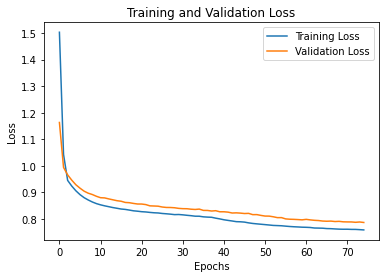

107/107 [==============================] - 0s 2ms/step


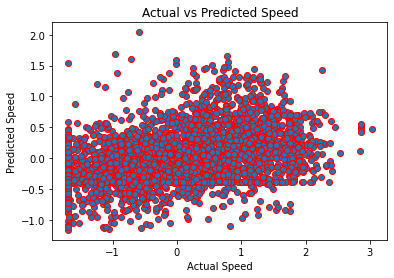

107/107 [==============================] - 0s 1ms/step


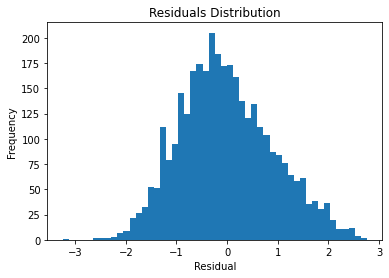

In [ ]:

# Plot the training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()



# Plot the actual vs predicted speeds
plt.scatter(y_test, model.predict(X_test), edgecolors='r')
plt.xlabel('Actual Speed')
plt.ylabel('Predicted Speed')
plt.title('Actual vs Predicted Speed')
plt.show()

# Plot the residuals
residuals = y_test - model.predict(X_test)
plt.hist(residuals, bins=50)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()

## Optional: Perform Hyperparameter tuning using Grid Search for finding the best parameters

In [ ]:
#from hyperparameter_tuning
#run_hyperparameter_tuning(X_train,y_train)